# Cargar Dataset

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
csv_path = 'bbc-news-data.csv'

if os.path.exists(csv_path):
    print("El archivo existe. Procediendo a cargarlo...")
    try:
        df = pd.read_csv('bbc-news-data.csv', sep='\t', engine='python')
        print("Archivo cargado exitosamente.")
        display(df.head())
    except pd.errors.ParserError as e:
        print("Error al parsear el archivo CSV:", e)
    except Exception as e:
        print("Ocurrió un error al cargar el archivo:", e)
else:
    print("El archivo no existe en la ruta especificada:", csv_path)


El archivo existe. Procediendo a cargarlo...
Archivo cargado exitosamente.


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [ ]:
print(df.shape)
print(df.columns)
df['category'].value_counts()


(2225, 4)
Index(['category', 'filename', 'title', 'content'], dtype='object')


,count
category,
sport,511
business,510
politics,417
tech,401
entertainment,386


# Prueba Rápida con un Clasificador Clásico

Dividir en entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split

X = df['title'].values
y = df['category'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Vectorizar y entrenar un clasificador

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)
print(classification_report(y_test, y_pred))


               precision    recall  f1-score   support

     business       0.77      0.90      0.83       102
entertainment       0.92      0.84      0.88        77
     politics       0.93      0.74      0.82        84
        sport       0.84      0.93      0.88       102
         tech       0.93      0.88      0.90        80

     accuracy                           0.86       445
    macro avg       0.88      0.86      0.86       445
 weighted avg       0.87      0.86      0.86       445



# Prototipo de QNLP con lambeq

In [ ]:
!pip install lambeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Preparar Oraciones Cortas**

Como lambeq usa gramáticas pregrupo, es recomendable usar titulares con pocas palabras y evitar puntuación rara o símbolos.

In [ ]:
# Filtrar titulares con longitud mayor a 10 palabras
def word_count(sentence):
    return len(sentence.split())

filtered = []
for text, cat in zip(X_train, y_train):
    if word_count(text) <= 10:
        filtered.append((text, cat))

print(len(filtered))

1780


**Normalizar las Oraciones**

Los parsers de gramática pregrupo pueden fallar cuando la frase:

*   Contiene contracciones
*   Tiene signos de puntuación o construcciones no contempladas en su gramática interna.
*   Contiene tokens “extraños” o demasiados adjetivos/apóstrofes para la estructura esperada.



In [ ]:
def clean_sentence(sentence):
    sentence = sentence.replace("'s", "s")  # "dollar's" -> "dollars"
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence

def add_period(sentence):
    sentence = sentence.strip()
    if not sentence.endswith('.'):
        sentence += '.'
    return sentence

**Crear Diagramas con lambeq**

In [ ]:
import spacy
from lambeq import BobcatParser
from lambeq.text2diagram.bobcat_parser import BobcatParseError
import re

errors = 0
parser = BobcatParser(root_cats=['S'])  # S = sentence
nlp = spacy.load('en_core_web_sm')

train_sents = [ (text, cat) for (text, cat) in filtered ]

diagrams = []
for text, cat in train_sents:
    try:

        print(f"Analizando la oración: {text}")
        text_clean = clean_sentence(text)
        text_clean = add_period(text_clean)
        diag = parser.sentence2diagram(text_clean)
        diagrams.append((diag, cat))
    except BobcatParseError:
        print(f"Error al analizar la oración: {text_clean}")
        errors += 1
        continue

print(f"{errors} errores al analizar oraciones")


Evaluating checksum: 0.0%|          |0.000/1.533GB [00:00<?]

Extracting model...
Analizando la oración: Asian banks halt dollar's slide
Analizando la oración: GB quartet get cross country call
Analizando la oración: Spider-Man creator wins profits
Analizando la oración: Howard unveils election platform
Analizando la oración: Police probe BNP mosque leaflet
Analizando la oración: Holmes urged to compete at Worlds
Analizando la oración: Kenyan school turns to handhelds
Analizando la oración: Philippoussis doubt over Open bid
Analizando la oración: Mourinho plots impressive course
Analizando la oración: Lloyd's of London head chides FSA
Analizando la oración: Cole faces lengthy injury lay-off
Analizando la oración: US box office set for record high
Analizando la oración: Player burn-out worries Robinson
Analizando la oración: UKIP's secret weapon?
Error al analizar la oración: UKIPs secret weapon.
Analizando la oración: BMW reveals new models pipeline
Analizando la oración: Honour for UK games maker
Error al analizar la oración: Honour for UK games

In [ ]:
print(len(diagrams))

1589


Diagrama 1 (Categoría: business)


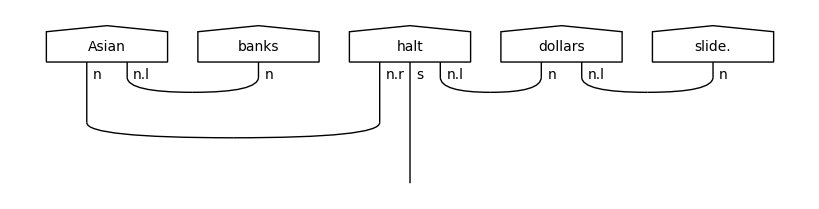

Diagrama 2 (Categoría: sport)


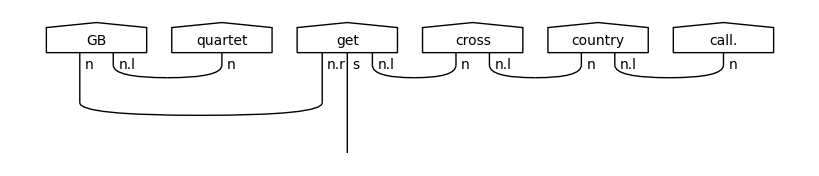

Diagrama 3 (Categoría: entertainment)


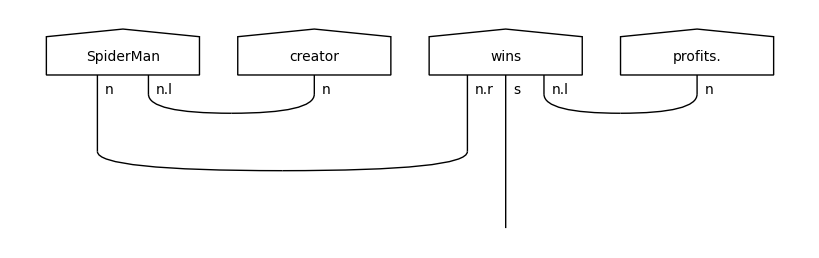

Diagrama 4 (Categoría: politics)


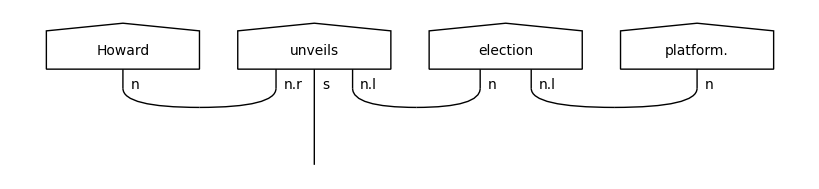

Diagrama 5 (Categoría: politics)


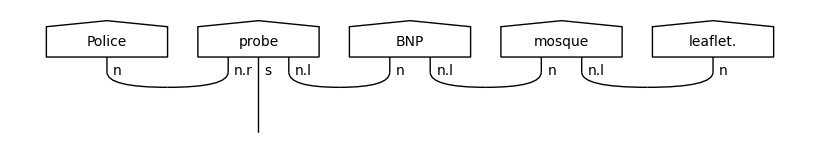

In [ ]:
for i, (diagram, category) in enumerate(diagrams[:5]):
    try:
      print(f"Diagrama {i+1} (Categoría: {category})")
      diagram.draw(figsize=(8, 6))

    except Exception as e:
      print(f"Error al dibujar el diagrama {i+1}: {e}")


**Convertir Diagramas a Circuitos Cuánticos Parametrizados**

Lambeq ofrece diferentes ansatz para mapear diagramas a circuitos. Por ejemplo, StronglyEntanglingAnsatz.

In [ ]:
all_types = set()
for diag, _ in diagrams:
    for box in diag.boxes:
        for subty in box.cod:
            all_types.add(subty)

print("Tipos atómicos encontrados:")
for t in all_types:
    print(t)

Tipos atómicos encontrados:
p.l
s.l
p
n
n.r
n.l.l
s
s.r
n.r.r
n.l


Filtro por falta de RAM

In [ ]:
# solo 2 categorías
reduced_data = [(diag, cat) for diag, cat in diagrams if cat in {'sport', 'tech'}]

In [ ]:
from lambeq import StronglyEntanglingAnsatz, AtomicType

#Mapa de tipos a qubits
ob_map = {
    AtomicType.NOUN: 1,
    AtomicType.CONJUNCTION: 1,
    AtomicType.PREPOSITIONAL_PHRASE: 1,
    AtomicType.SENTENCE: 1,
    AtomicType.PUNCTUATION: 1,
    AtomicType.NOUN_PHRASE: 1,
}

#Crear el ansatz
ansatz = StronglyEntanglingAnsatz(
    ob_map=ob_map,
    n_layers=2,
    n_single_qubit_params=3
)

#Convertir diagramas -> circuitos
circuits = []
for diag, cat in reduced_data:
    circuit = ansatz(diag)
    circuits.append((circuit, cat))


Circuito 0 (categoría: sport)


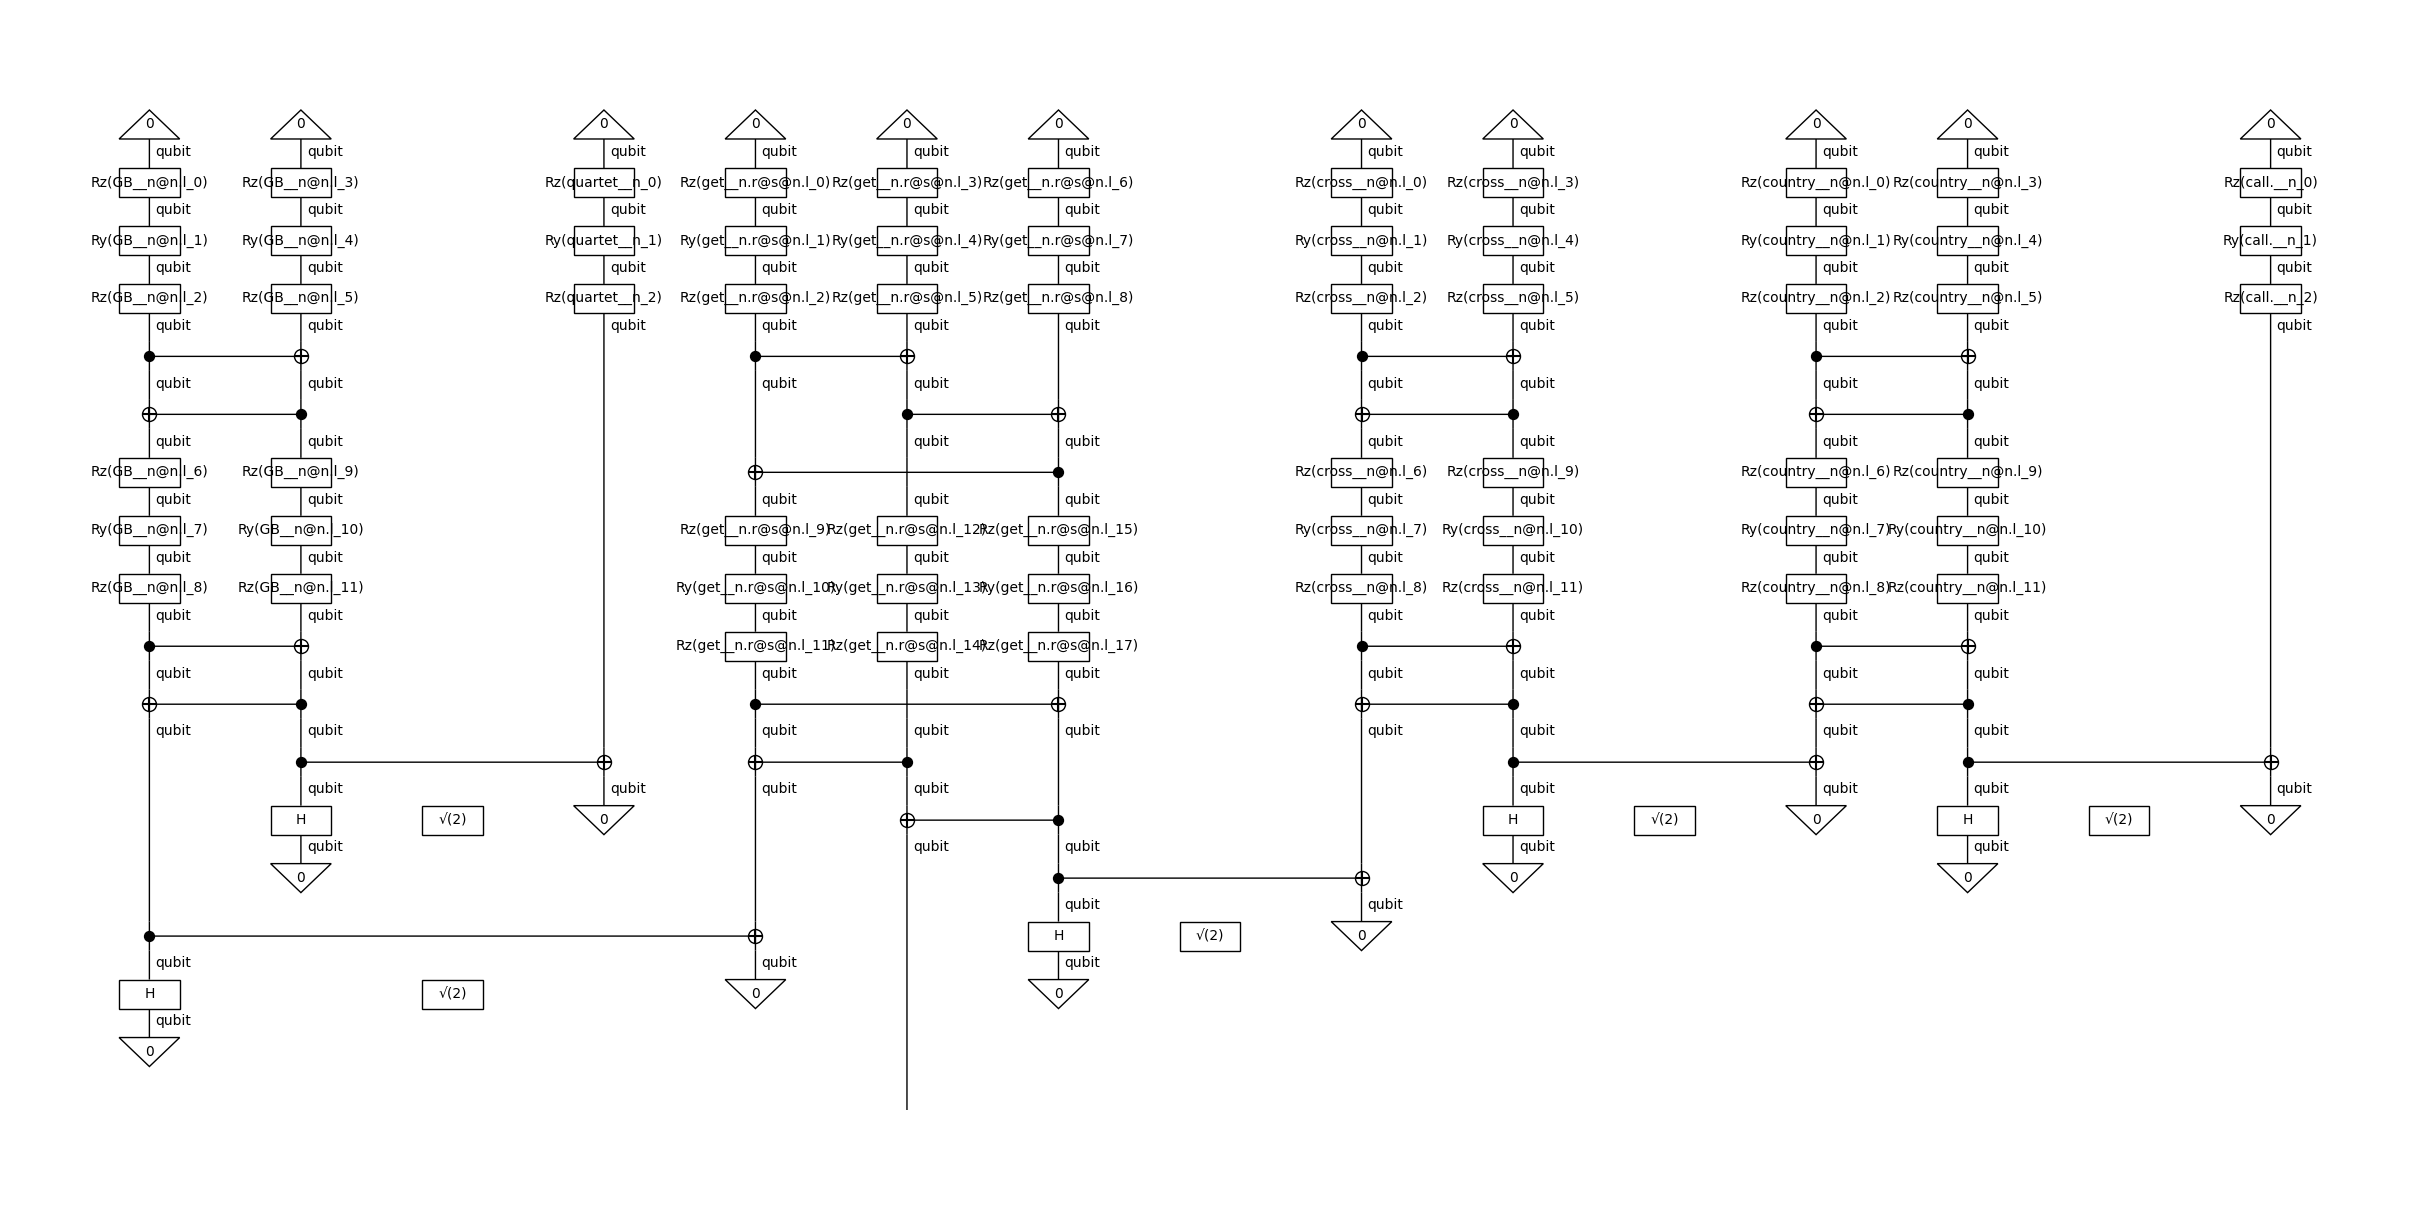

Circuito 1 (categoría: sport)


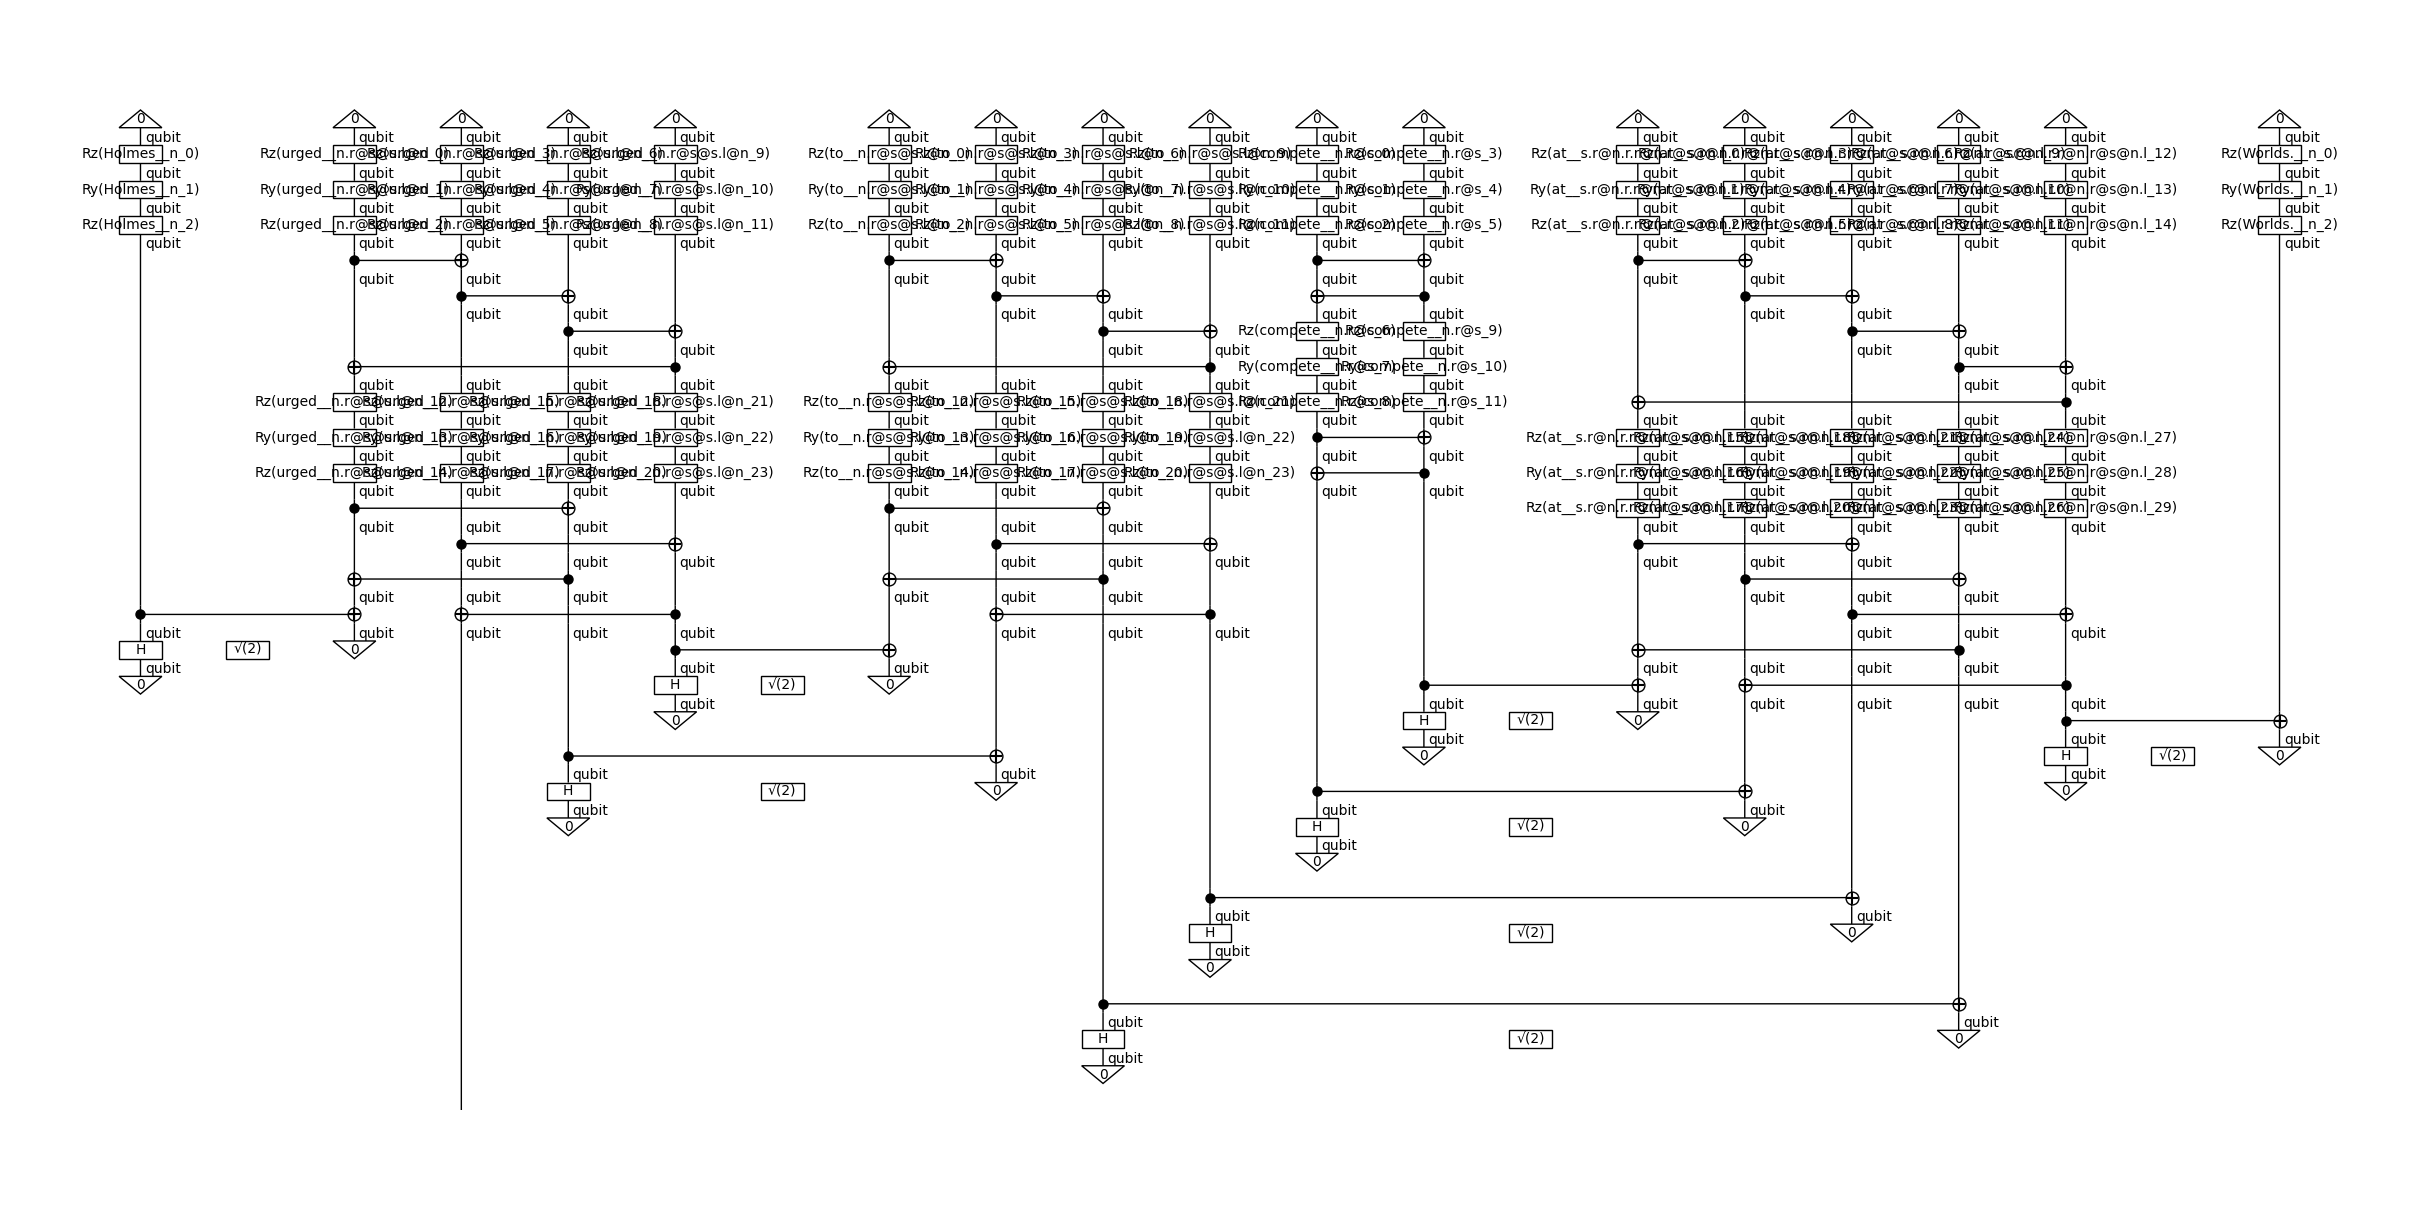

Circuito 2 (categoría: tech)


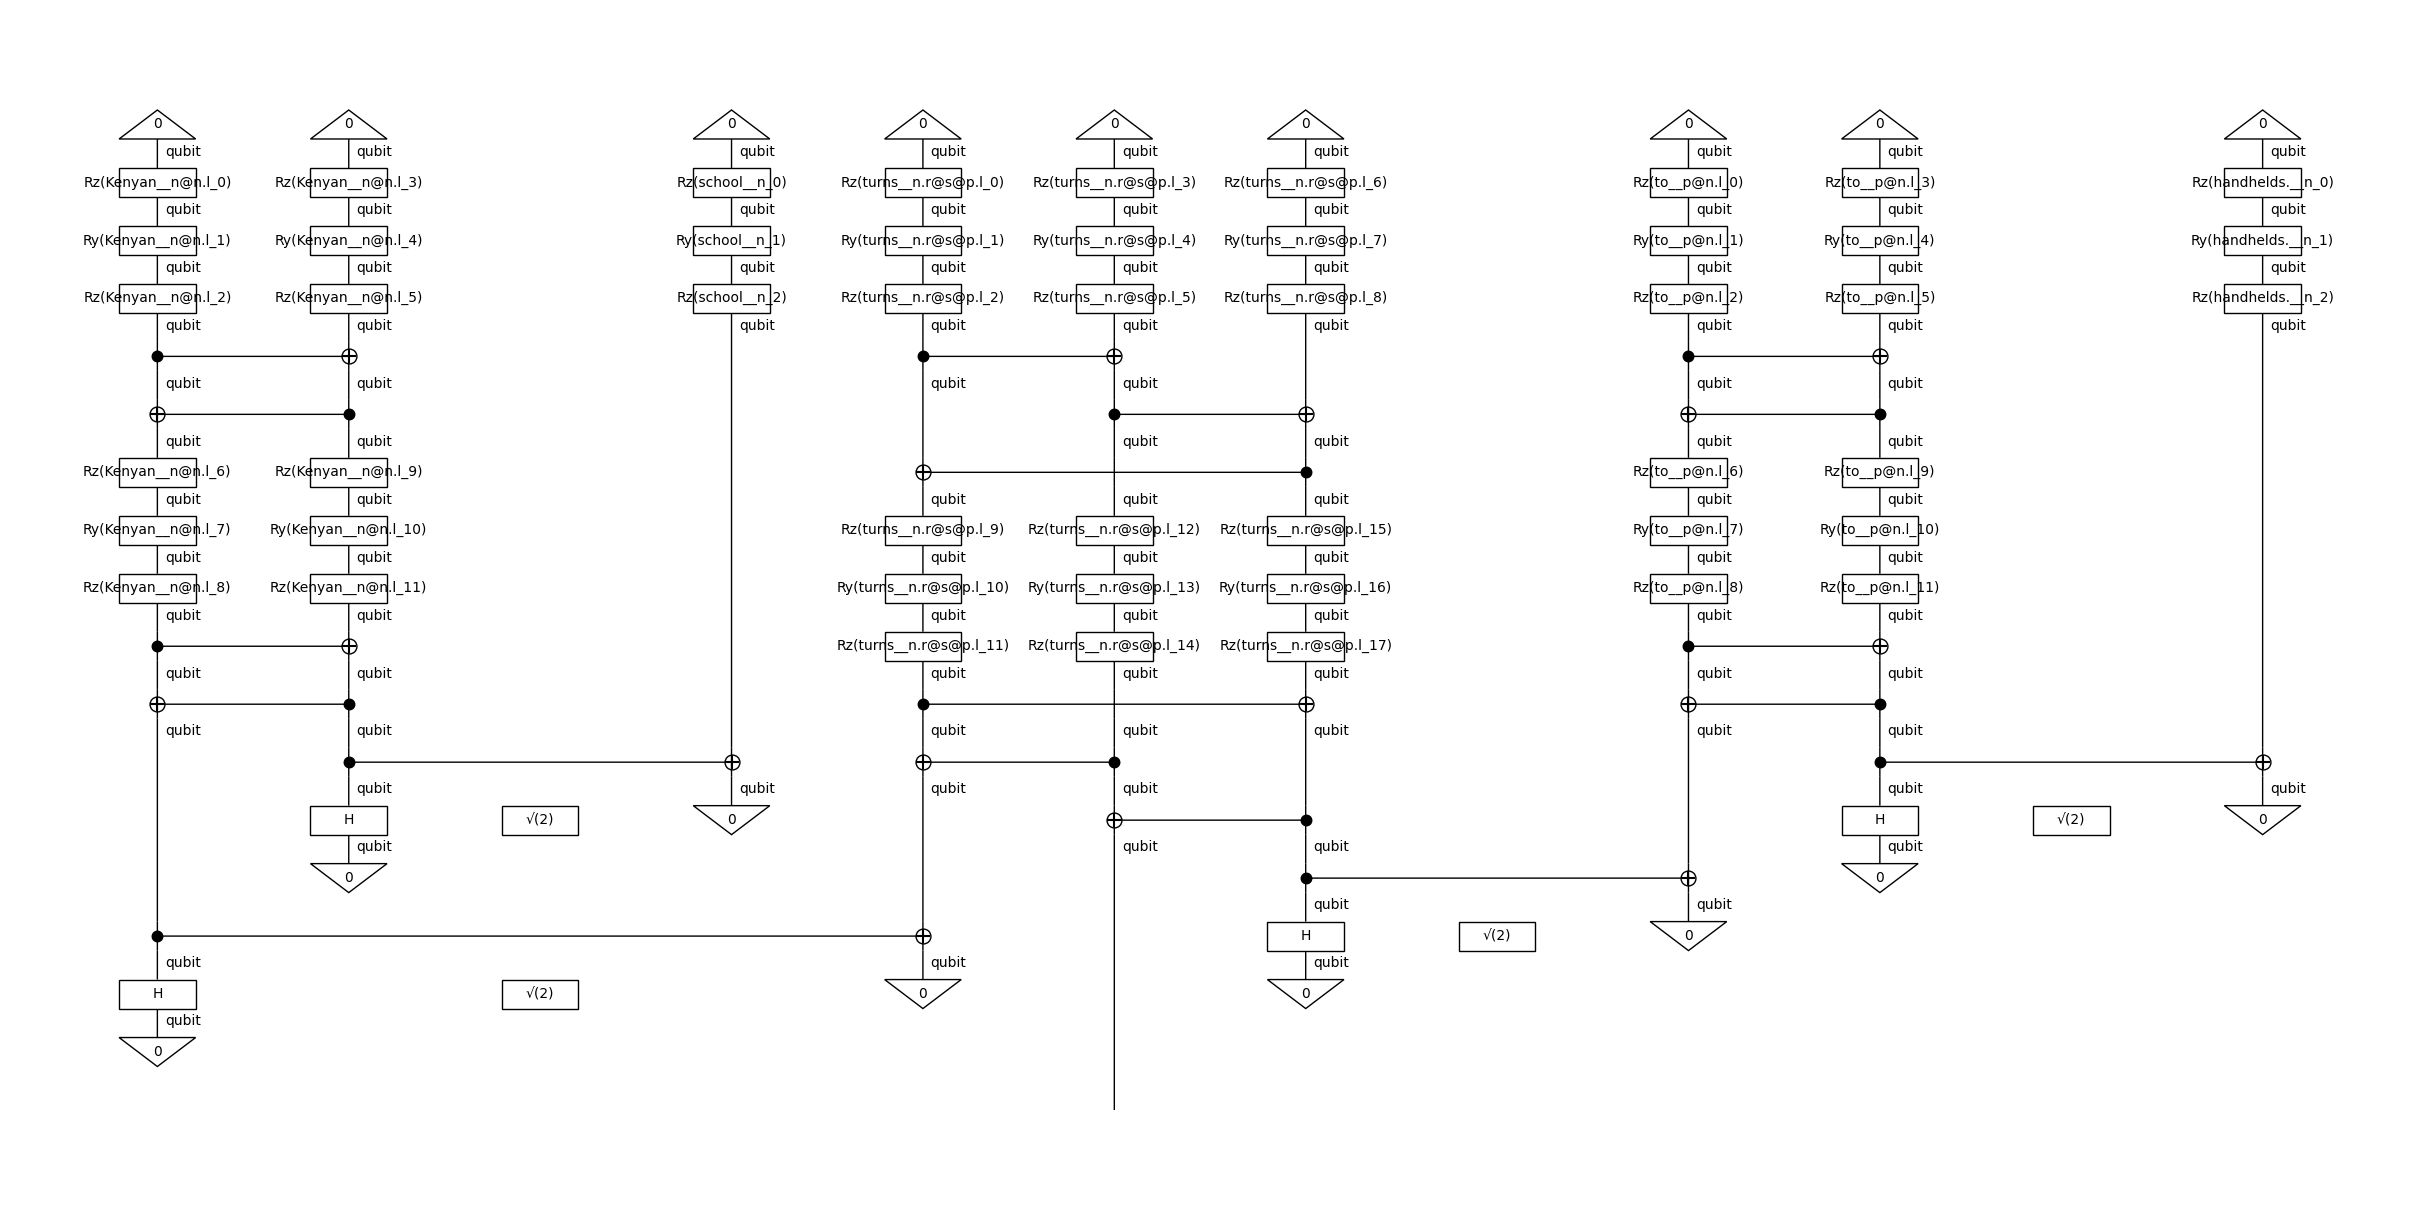

In [ ]:
for i, (circuit, cat) in enumerate(circuits[:3]):
    print(f"Circuito {i} (categoría: {cat})")
    circuit.draw(figsize=(24,12))


**Definir Etiquetas y Backend Cuántico**

In [ ]:
!pip install lambeq[extras]
!pip install torch opt_einsum

INFO: pip is looking at multiple versions of pennylane-qiskit to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of pennylane-lightning to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 3

In [ ]:
import torch
from lambeq import (
    PennyLaneModel, Dataset, PytorchTrainer
)

BATCH_SIZE = 10
EPOCHS = 15
LEARNING_RATE = 0.1
SEED = 42

torch.manual_seed(SEED)

# etiquetas categóricas a valores enteros
label_map = {
    'sport': 0,
    'tech': 1
}

X = [circ for circ, _ in circuits]
y = [label_map[label] for _, label in circuits]

backend_config = {'backend': 'default.qubit'}  # Simulador de PennyLane
model = PennyLaneModel.from_diagrams(
    X,
    probabilities=True,
    normalize=True,       # Normalizar probabilidades para estabilidad
    backend_config=backend_config
)

model.output_dim = 5
model.initialise_weights()

train_dataset = Dataset(X, y, batch_size=BATCH_SIZE)

def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) == torch.tensor(y)).sum().item() / len(y)

def loss(y_hat, y):
    return torch.nn.functional.cross_entropy(y_hat, torch.tensor(y).clone().detach().long())

trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED
)

**Entrenamiento y Evaluación**

In [ ]:
trainer.fit(train_dataset)

with torch.no_grad():
    predictions = model(X)
    accuracy = acc(predictions, y)
    print(f'Precisión final en el conjunto de entrenamiento: {accuracy:.4f}')


<ipython-input-18-94a20d64876c>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.nn.functional.cross_entropy(y_hat, torch.tensor(y).clone().detach().long())
<ipython-input-18-94a20d64876c>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.argmax(y_hat, dim=1) == torch.tensor(y)).sum().item() / len(y)
Epoch 1:   train/loss: 0.4971   valid/loss: -----   train/time: 4m59s   valid/time: -----   train/acc: 0.5291   valid/acc: -----
Epoch 2:   train/loss: 0.7715   valid/loss: -----   train/time: 4m57s   valid/time: -----   train/acc: 0.5963   valid/acc: -----
Epoch 3:   train/loss: 0.4878   valid/loss: -----   train/time: 5m7s   valid/time: -----   train/acc: 0.6376

Precisión final en el conjunto de entrenamiento: 0.8287


Guardar el modelo

In [ ]:
MODEL_SAVE_PATH = "quantum_classifier.lt"
model.save(MODEL_SAVE_PATH)
print(f"Modelo guardado en: {MODEL_SAVE_PATH}")

Modelo guardado en: quantum_classifier.lt


In [ ]:
# Cargar el modelo desde el checkpoint
MODEL_SAVE_PATH = "quantum_classifier.lt"
model = PennyLaneModel.from_checkpoint(MODEL_SAVE_PATH)
model.eval()  # Cambiar a modo de evaluación

PennyLaneModel(
  (weights): ParameterList(
      (0): Parameter containing: [torch.float32 of size ]
      (1): Parameter containing: [torch.float32 of size ]
      (2): Parameter containing: [torch.float32 of size ]
      (3): Parameter containing: [torch.float32 of size ]
      (4): Parameter containing: [torch.float32 of size ]
      (5): Parameter containing: [torch.float32 of size ]
      (6): Parameter containing: [torch.float32 of size ]
      (7): Parameter containing: [torch.float32 of size ]
      (8): Parameter containing: [torch.float32 of size ]
      (9): Parameter containing: [torch.float32 of size ]
      (10): Parameter containing: [torch.float32 of size ]
      (11): Parameter containing: [torch.float32 of size ]
      (12): Parameter containing: [torch.float32 of size ]
      (13): Parameter containing: [torch.float32 of size ]
      (14): Parameter containing: [torch.float32 of size ]
      (15): Parameter containing: [torch.float32 of size ]
      (16): Parameter 

              precision    recall  f1-score   support

       sport       0.84      0.87      0.86       382
        tech       0.81      0.78      0.79       272

    accuracy                           0.83       654
   macro avg       0.82      0.82      0.82       654
weighted avg       0.83      0.83      0.83       654



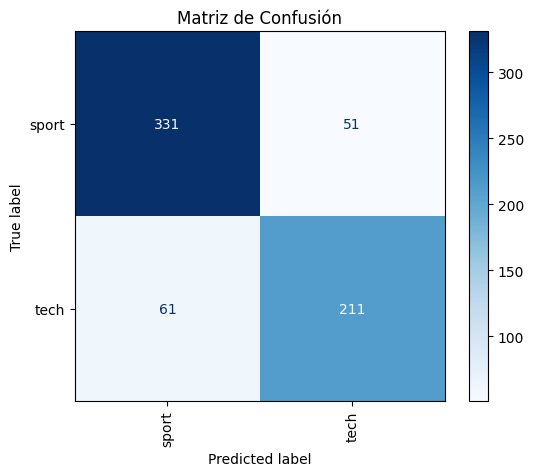

In [ ]:
import os
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics(y_pred, y_true):
    y_pred_classes = torch.argmax(y_pred, dim=1).tolist()
    y_true = y_true.tolist()
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    return f1, precision, recall

with torch.no_grad():
    predictions = model(X)  # X son los circuitos
    predicted_labels = torch.argmax(predictions, dim=1).tolist()


true_labels = y  # Etiquetas reales que corresponden a los circuitos

print(classification_report(true_labels, predicted_labels, target_names=label_map.keys()))

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Matriz de Confusión")
plt.show()

